In [1]:
import numpy as np 
import pandas as pd 
import gensim
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dataset/sample_submission.csv/sample_submission.csv
/kaggle/input/dataset/train.json/train.json
/kaggle/input/dataset/test.json/test.json


In [2]:
train_data="/kaggle/input/dataset/train.json/train.json"
test_data="/kaggle/input/dataset/test.json/test.json"
train= pd.read_json(train_data)
test= pd.read_json(test_data)

print("Train Data:")
df = pd.DataFrame(train)
print(df)
print("Test Data:")
t_df = pd.DataFrame(test)
#tl = pd.DataFrame(test_label)
print(t_df)


Train Data:
          id      cuisine                                        ingredients
0      10259        greek  [romaine lettuce, black olives, grape tomatoes...
1      25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2      20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3      22213       indian                [water, vegetable oil, wheat, salt]
4      13162       indian  [black pepper, shallots, cornflour, cayenne pe...
...      ...          ...                                                ...
39769  29109        irish  [light brown sugar, granulated sugar, butter, ...
39770  11462      italian  [KRAFT Zesty Italian Dressing, purple onion, b...
39771   2238        irish  [eggs, citrus fruit, raisins, sourdough starte...
39772  41882      chinese  [boneless chicken skinless thigh, minced garli...
39773   2362      mexican  [green chile, jalapeno chilies, onions, ground...

[39774 rows x 3 columns]
Test Data:
         id                

# Preprocessing

## Warning: the following line of code was executed only once in order to download wordnet manually, as I was having troubling importing the library. Don't forget to comment the line again if the code is rerun.

In [3]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [4]:
#lemmatizing words in the ingredients collumn using the WordNetLemmatizer library and removing some common ingredient preparations methods/redudant words that might
#consider the same ingredients as two different ones (example: "large egg yolk/egg yolk", "crsuhed garlic/garlic")

from nltk.stem import WordNetLemmatizer
import re


lemmatizer = WordNetLemmatizer()

def preprocess_data(df):
    def process_string(x):
        x = [" ".join([lemmatizer.lemmatize(q) for q in p.split()]) for p in x]
        x = list(map(lambda x: re.sub(r'\(.*oz.\)|crushed|crumbles|ground|minced|powder|chopped|sliced|fresh|baked|boiled|broiled|canned|cooked|cubed|diced|dried|fried|grated|juiced|mashed|peeled|pickled|roasted|shredded|smoked|steamed|stewed|toasted|large|small|clove','', x), x))
        x = list(map(lambda x: re.sub("[^a-zA-Z]", " ", x), x))
        return x
    
    df['ingredients'] = df['ingredients'].apply(process_string)
    
    return df

df = preprocess_data(df)
t_df = preprocess_data(t_df)

print(df)
print(t_df)

          id      cuisine                                        ingredients
0      10259        greek  [romaine lettuce, black olive, grape tomato, g...
1      25693  southern_us  [plain flour,  pepper, salt, tomato,  black pe...
2      20130     filipino  [egg, pepper, salt, mayonaise, cooking oil, gr...
3      22213       indian                [water, vegetable oil, wheat, salt]
4      13162       indian  [black pepper, shallot, cornflour, cayenne pep...
...      ...          ...                                                ...
39769  29109        irish  [light brown sugar, granulated sugar, butter, ...
39770  11462      italian  [KRAFT Zesty Italian Dressing, purple onion, b...
39771   2238        irish  [egg, citrus fruit, raisin, sourdough starter,...
39772  41882      chinese  [boneless chicken skinless thigh,  garlic,  wh...
39773   2362      mexican  [green chile, jalapeno chilies, onion,  black ...

[39774 rows x 3 columns]
         id                                       

In [5]:
#setting collumns on both dataframes to lowercase and removing any extra spaces that might have stayed from the lemmetization

#train dataset
df['cuisine']=df['cuisine'].str.lower()
df['ingredients'] = df['ingredients'].apply(lambda lst: [s.lower() for s in lst])

#test dataset
t_df['ingredients'] = t_df['ingredients'].apply(lambda lst: [s.lower() for s in lst])

#removing all spaces or pontuational characters. This way it doesn't count the same word as two different ones.
df['ingredients'] = df['ingredients'].apply(lambda lst: [re.sub('[-_, ]', '', s) for s in lst])
t_df['ingredients'] = t_df['ingredients'].apply(lambda lst: [re.sub('[-_, ]', '', s) for s in lst])


print(df)
print(t_df)


          id      cuisine                                        ingredients
0      10259        greek  [romainelettuce, blackolive, grapetomato, garl...
1      25693  southern_us  [plainflour, pepper, salt, tomato, blackpepper...
2      20130     filipino  [egg, pepper, salt, mayonaise, cookingoil, gre...
3      22213       indian                 [water, vegetableoil, wheat, salt]
4      13162       indian  [blackpepper, shallot, cornflour, cayennepeppe...
...      ...          ...                                                ...
39769  29109        irish  [lightbrownsugar, granulatedsugar, butter, war...
39770  11462      italian  [kraftzestyitaliandressing, purpleonion, brocc...
39771   2238        irish  [egg, citrusfruit, raisin, sourdoughstarter, f...
39772  41882      chinese  [bonelesschickenskinlessthigh, garlic, whiteri...
39773   2362      mexican  [greenchile, jalapenochilies, onion, blackpepp...

[39774 rows x 3 columns]
         id                                       

# Dataset Distribution Analysis

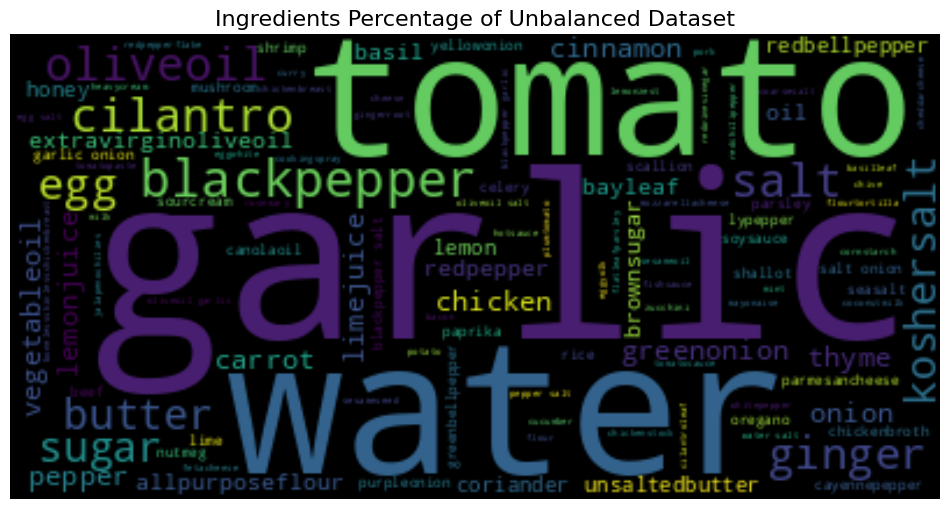

In [6]:
#let's generally visualize what ingredients are the most common

from wordcloud import WordCloud

all_ingredients_df = []
for recipe in df['ingredients']:
        for ingredient in recipe:
            all_ingredients_df.append(ingredient)

def plot_wordcloud(text, title=None, max = 1000, size=(12,8), title_size=16):
    """plots wordcloud"""
    wordcloud = WordCloud(max_words=max).generate(text)
    plt.figure(figsize=size)
    plt.title(title, size=title_size)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

plot_wordcloud(' '.join(all_ingredients_df), title='Ingredients Percentage of Unbalanced Dataset')

### It is clear that despite the most obvious ingredients, like garlic and water, some of the most common ingredients are from typical italian recipes, like tomato. 

## Let's analize this more concretely

<Axes: xlabel='cuisine'>

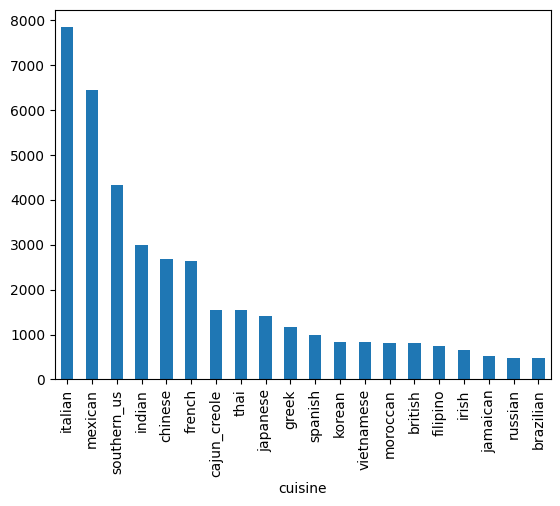

In [7]:
#plotting the cuisine type distribution through the dataset
train.cuisine.value_counts().plot.bar()

## We can see that there are a lot more entries labeled as italian and mexican, when compared to the other classes.

## We can try to downsample the dataset randomly, in order to have the same number of entries for each label.

In [8]:
from sklearn.utils import resample

# Find the minimum number of samples in any class
min_count = df['cuisine'].value_counts().min()

# Downsample each class to the minimum number of samples, in this case, the brazilian labeled samples
balanced_df_list = []
for label in df['cuisine'].unique():
    df_label = df[df['cuisine'] == label]
    df_label_downsampled = resample(df_label, replace=False, n_samples=min_count, random_state=42)
    balanced_df_list.append(df_label_downsampled)

balanced_df = pd.concat(balanced_df_list)

# Shuffle the DataFrame to mix the rows
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)







#uncomment this line in order to train the model with the balanced dataset
#df=balanced_df

# Check the class distribution
print("Unbalanced Dataset Entries Distribution:")
print(df['cuisine'].value_counts())
print("Balanced Dataset Entries Distribution:")
print(balanced_df['cuisine'].value_counts())

Unbalanced Dataset Entries Distribution:
cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: count, dtype: int64
Balanced Dataset Entries Distribution:
cuisine
greek           467
russian         467
vietnamese      467
korean          467
japanese        467
filipino        467
thai            467
indian          467
british         467
southern_us     467
irish           467
cajun_creole    467
chinese         467
italian         467
brazilian       467
jamaican        467
moroccan        467
french          467
spanish         467
mexican         467
Name: count, dtype: int64


## Let's now verify if downsampling represents any difference on the impact each ingredient has:

Top 10 ingredients in all_ingredients_df:
salt: 4.214348257544802
garlic: 4.204074484852023
onion: 2.390286614908645
oliveoil: 1.8614208160644445
water: 1.7411709765921428
blackpepper: 1.7308972038993637
sugar: 1.502305761485027
egg: 1.4868951024458585
tomato: 1.402369972564357
butter: 1.1319829548771234

Top 10 ingredients in all_ingredients_balanced:
salt: 4.224867204406847
garlic: 4.172732638205784
onion: 2.5270509541609285
water: 1.9102891992917568
sugar: 1.820775132795593
blackpepper: 1.7391304347826086
oliveoil: 1.5699390123942554
egg: 1.5581349596694865
ginger: 1.3997639189455047
pepper: 1.2364745229195357


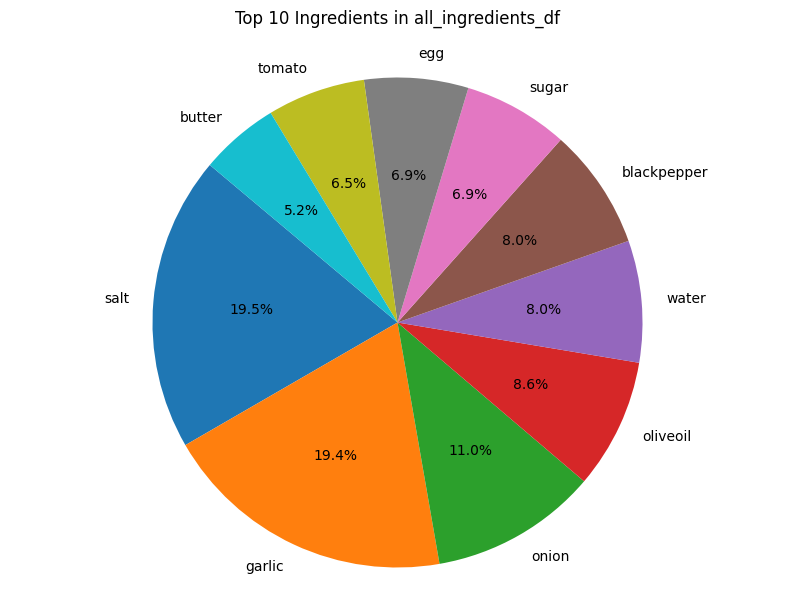

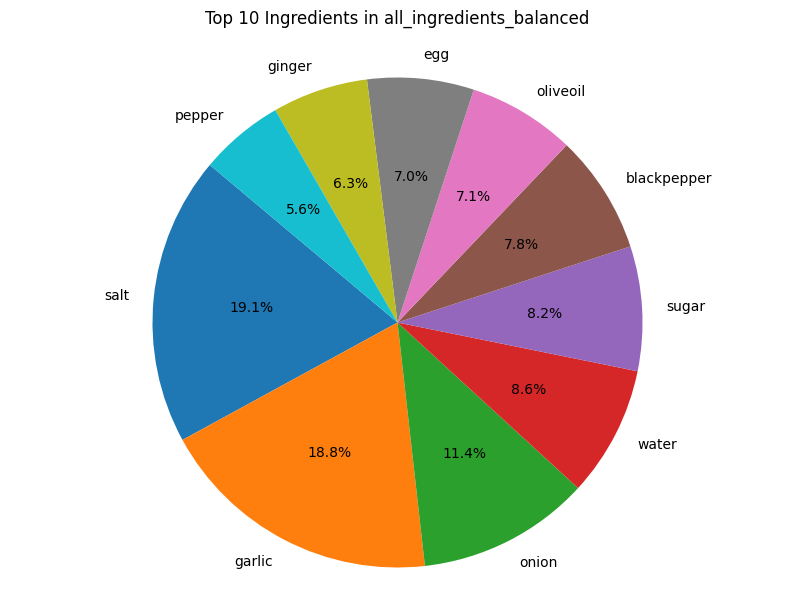

In [9]:
#counts the number of times each ingredient appears and plots what the most common ingredients in each dataset are:

from collections import Counter
            
all_ingredients_balanced = []
for recipe in balanced_df['ingredients']:
        for ingredient in recipe:
            all_ingredients_balanced.append(ingredient)
            
            
            
counter_all_ingredients = Counter(all_ingredients_df)


top_10_all_ingredients = counter_all_ingredients.most_common(10)


counter_all_ingredients_balanced = Counter(all_ingredients_balanced)

top_10_all_ingredients_balanced = counter_all_ingredients_balanced.most_common(10)


print("Top 10 ingredients in all_ingredients_df:")

for ingredient, count in top_10_all_ingredients:
    print(f"{ingredient}: {(count/len(all_ingredients_df))*100}")

print("\nTop 10 ingredients in all_ingredients_balanced:")

for ingredient, count in top_10_all_ingredients_balanced:
    print(f"{ingredient}: {(count/len(all_ingredients_balanced))*100}")
    
ingredients, counts = zip(*top_10_all_ingredients)
    
plt.figure(figsize=(10, 7))
plt.pie(counts, labels=ingredients, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Ingredients in all_ingredients_df\n')
plt.axis('equal')  
plt.show()

ingredients, counts = zip(*top_10_all_ingredients_balanced)
print("\n\n\n\n")
plt.figure(figsize=(10, 7))
plt.pie(counts, labels=ingredients, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Ingredients in all_ingredients_balanced\n')
plt.axis('equal') 
plt.show()

# Model Training Preparation

In [10]:
#converting the cuisine column to labels in order to be read by the model

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(df['cuisine'])

# Transform the 'cuisine' column to integer labels
df['label'] = label_encoder.transform(df['cuisine'])
#balanced_df['label'] = label_encoder.transform(balanced_df['cuisine'])

In [11]:
#process of converting the array to string for later tokenizing the ingredients, as common practice

def array_to_string(array):
    text = ' '.join(array)
    
    return text

df['ingredients_2'] = df['ingredients'].apply(array_to_string)
#balanced_df['ingredients_2'] = balanced_df['ingredients'].apply(array_to_string)
t_df['ingredients_2'] = t_df['ingredients'].apply(array_to_string)

print(df)
print(t_df)

          id      cuisine                                        ingredients  \
0      10259        greek  [romainelettuce, blackolive, grapetomato, garl...   
1      25693  southern_us  [plainflour, pepper, salt, tomato, blackpepper...   
2      20130     filipino  [egg, pepper, salt, mayonaise, cookingoil, gre...   
3      22213       indian                 [water, vegetableoil, wheat, salt]   
4      13162       indian  [blackpepper, shallot, cornflour, cayennepeppe...   
...      ...          ...                                                ...   
39769  29109        irish  [lightbrownsugar, granulatedsugar, butter, war...   
39770  11462      italian  [kraftzestyitaliandressing, purpleonion, brocc...   
39771   2238        irish  [egg, citrusfruit, raisin, sourdoughstarter, f...   
39772  41882      chinese  [bonelesschickenskinlessthigh, garlic, whiteri...   
39773   2362      mexican  [greenchile, jalapenochilies, onion, blackpepp...   

       label                           

In [12]:
#split training dataset into training and validation

from sklearn.model_selection import train_test_split

x_train , x_val ,y_train , y_val = train_test_split(df['ingredients_2'].values , df['label'].values , test_size=0.2, random_state = 42)

In [13]:
#tokenizing the now splitted datasets

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

tokenizer = Tokenizer(num_words = None)
tokenizer.fit_on_texts(list(x_train))

train_seq = tokenizer.texts_to_sequences(list(x_train))
val_seq = tokenizer.texts_to_sequences(list(x_val))
test_seq = tokenizer.texts_to_sequences(list(t_df.ingredients_2.values))

max_len = max(max(len(seq) for seq in train_seq), 
              max(len(seq) for seq in val_seq), 
              max(len(seq) for seq in test_seq))

train_seq_pad = pad_sequences(train_seq, maxlen=max_len)
val_seq_pad = pad_sequences(val_seq, maxlen=max_len)
test_seq_pad = pad_sequences(test_seq, maxlen=max_len)

print(len(tokenizer.word_index) + 1)
teste=tokenizer.word_index

2024-06-05 15:19:30.913437: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 15:19:30.913535: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 15:19:31.027129: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


5675


# Model Training

In [14]:
#final model that presented the best results
#This model combines embedding, bidirectional LSTM layers, and dense layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional


model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=300))
model.add(Bidirectional(LSTM(units=100, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=100)))
model.add(Dropout(0.5))
model.add(Dense(units=20, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])


## The following commented lines consist of other models that were tested but produced rellatively lower results.

In [15]:
#Simple RNN

"""
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
rom keras.layers import Dense, Activation

model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 300))
model.add(SimpleRNN(100))
model.add(Dense(20, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
"""


"\nfrom keras.models import Sequential\nfrom keras.layers import Embedding, SimpleRNN\nrom keras.layers import Dense, Activation\n\nmodel = Sequential()\nmodel.add(Embedding(len(tokenizer.word_index) + 1, 300))\nmodel.add(SimpleRNN(100))\nmodel.add(Dense(20, activation='softmax'))\nmodel.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])\n"

In [16]:
#CNN model
"""
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=300))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(units=100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=20, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
"""

"\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout\n\nmodel = Sequential()\nmodel.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=300))\nmodel.add(Conv1D(filters=128, kernel_size=5, activation='relu'))\nmodel.add(GlobalMaxPooling1D())\nmodel.add(Dropout(0.5))\nmodel.add(Dense(units=100, activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(units=20, activation='softmax'))\nmodel.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])\n"

In [17]:
#GRU Model
"""
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dropout, Dense

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=300))
model.add(Bidirectional(GRU(units=100, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(GRU(units=100)))
model.add(Dropout(0.5))
model.add(Dense(units=20, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
"""

"\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dropout, Dense\n\nmodel = Sequential()\nmodel.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=300))\nmodel.add(Bidirectional(GRU(units=100, return_sequences=True)))\nmodel.add(Dropout(0.5))\nmodel.add(Bidirectional(GRU(units=100)))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(units=20, activation='softmax'))\nmodel.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])\n"

In [18]:
#Embeded Model that combines a CNN and RNN Model
"""
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dropout, Dense

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=300))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(units=100)))
model.add(Dropout(0.5))
model.add(Dense(units=100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=20, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
"""

"\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dropout, Dense\n\nmodel = Sequential()\nmodel.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=300))\nmodel.add(Conv1D(filters=128, kernel_size=5, activation='relu'))\nmodel.add(MaxPooling1D(pool_size=2))\nmodel.add(Bidirectional(LSTM(units=100)))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(units=100, activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(units=20, activation='softmax'))\nmodel.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])\n"

In [19]:
#Simple Dense Model
"""
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=300))
dmodel.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=20, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
"""

"\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout\n\nmodel = Sequential()\nmodel.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=300))\ndmodel.add(Flatten())\nmodel.add(Dense(units=128, activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(units=64, activation='relu'))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(units=20, activation='softmax'))\nmodel.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])\n"

In [20]:
#Trains the model with the training data
model.fit(train_seq_pad, y_train , epochs = 10 , batch_size = 64)

Epoch 1/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.4286 - loss: 1.9620
Epoch 2/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.7129 - loss: 0.9641
Epoch 3/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.7851 - loss: 0.7430
Epoch 4/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8159 - loss: 0.6406
Epoch 5/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8372 - loss: 0.5648
Epoch 6/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8563 - loss: 0.4973
Epoch 7/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8737 - loss: 0.4458
Epoch 8/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8824 - loss: 0.4067
Epoch 9/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8937 - loss: 0.3728
Epoch 10/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8999 - loss: 0.3449


# Results

In [21]:
#validates the trained model with the validation data

y_pred_probs = model.predict(val_seq_pad)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
results = pd.DataFrame({
    'y_true': y_val,
    'y_pred': y_pred
})

print(results)

249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
      y_true  y_pred
0          3       3
1         17      13
2          6       6
3          7       7
4          9       9
...      ...     ...
7950      13      13
7951       9       9
7952       3       3
7953       7       7
7954       5      16

[7955 rows x 2 columns]


In [22]:
#shows model results with both accuracy and F1_score, being the latest one the most revelant considering the number of classes

from sklearn.metrics import accuracy_score, f1_score
from sklearn import metrics


def calculate_scores(y_val, y_pred):
    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)
    
    # Calculate F1 score
    f1 = f1_score(y_val, y_pred, average='macro')  # Using macro to be fair, since it doesn't take into account the class inbalance
    
    return accuracy, f1

# Example usage:
accuracy, f1 = calculate_scores(y_val, y_pred)
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print(metrics.classification_report(y_val, y_pred))

Accuracy: 0.7499685732243871
F1 Score: 0.6560304230922471
              precision    recall  f1-score   support

           0       0.76      0.45      0.57        84
           1       0.43      0.46      0.45       157
           2       0.72      0.70      0.71       328
           3       0.78      0.81      0.79       510
           4       0.56      0.54      0.55       136
           5       0.59      0.59      0.59       550
           6       0.68      0.69      0.69       249
           7       0.86      0.84      0.85       602
           8       0.64      0.34      0.44       151
           9       0.83      0.82      0.83      1567
          10       0.71      0.71      0.71        91
          11       0.75      0.71      0.73       284
          12       0.73      0.79      0.76       166
          13       0.87      0.91      0.89      1336
          14       0.71      0.75      0.73       166
          15       0.34      0.51      0.41        89
          16       0.69

In [23]:
#the model classifies the testing data based on the training

test_pred_probs=model.predict(test_seq_pad)
test_pred = np.argmax(test_pred_probs, axis=1)
test_pred_label = label_encoder.inverse_transform(test_pred)
print(test_pred_label)

311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
['british' 'southern_us' 'italian' ... 'italian' 'southern_us' 'mexican']


In [24]:
#stores the classification similarly to the sample submited, on the output file called "submission.csv"

t_df.drop(columns=['ingredients'], inplace=True)
t_df.drop(columns=['ingredients_2'], inplace=True)

t_df['cuisine'] = test_pred_label
#print(final)
print(t_df)

t_df.to_csv('/kaggle/working/submission.csv', index=False)

         id       cuisine
0     18009       british
1     28583   southern_us
2     41580       italian
3     29752  cajun_creole
4     35687       italian
...     ...           ...
9939  30246        french
9940  36028   southern_us
9941  22339       italian
9942  42525   southern_us
9943   1443       mexican

[9944 rows x 2 columns]


# Final Remarks

### It is important to notice that the balanced dataset was producing worst results than the unbalanced one, which is a symptom from a typical problem where we have a high number of classes but only a few samples for each class, which translates to undefined predictions and low average results. Overall, I believe the results were satisfying, considering the multiclass problem difficulty and the unbalancing of the dataset. If only italians didn't make such good food...  